In [1]:
### Import Statements
import sys, os, json, tqdm
sys.path.append('..')

In [2]:
### API Keys and Clients
from openai import OpenAI
from together import Together
from lib.utils.utils import load_api_keys
KEYS = load_api_keys()
client = OpenAI(api_key = KEYS["openai"])
client_together = Together(api_key=KEYS["togetherai"])

In [3]:
### Generate Dataset
from lib.data_generation.generate_dataset import generate_dataset
# NLP4LP
source_dataset_folder = '../data/nlp4lp'
target_dataset_folder = '../data/nlp4lp_task_disambiguation'
# complete_problems, incomplete_problems = generate_dataset(source_dataset_folder, target_dataset_folder, client)
# print('complete problems:', len(complete_problems), '\nincomplete problems:', len(incomplete_problems))
# NLOPT
source_dataset_folder = '../data/nl4opt'
target_dataset_folder = '../data/nl4opt_task_disambiguation'
# complete_problems, incomplete_problems = generate_dataset(source_dataset_folder, target_dataset_folder, client)
# print('complete problems:', len(complete_problems), '\nincomplete problems:', len(incomplete_problems))
# Complexor
source_dataset_folder = '../data/complexor'
target_dataset_folder = '../data/complexor_task_disambiguation'
# complete_problems, incomplete_problems = generate_dataset(source_dataset_folder, target_dataset_folder, client)
# print('complete problems:', len(complete_problems), '\nincomplete problems:', len(incomplete_problems))

In [4]:
DATASET_FOLDER = '../data/complexor_task_disambiguation'

In [5]:
### Dataset Statistics
import pandas as pd
from lib.utils.utils import check_file_existence

def dict_to_df(all_data):
    rows = []
    for dataset_name, dataset_data in all_data.items():
        for problem_idx_key, problem_idx_data in dataset_data.items():
            for key, data in problem_idx_data.items():
                row = {"Dataset Name": dataset_name, "Problem Index": problem_idx_key,'Field': key,'Data': data}
                rows.append(row)
            df = pd.DataFrame(rows)
    return df

dataset_folders = {"nlp4lp" : "../data/nlp4lp_task_disambiguation", "nl4opt": "../data/nl4opt_task_disambiguation", "complexor" : "../data/complexor_task_disambiguation"}
all_data = {}
for dataset_name, dataset_folder in dataset_folders.items():
    problems = [f for f in os.listdir(dataset_folder) if os.path.isdir(os.path.join(dataset_folder, f))]
    source_problem_paths = {problem: dataset_folder + '/' + problem + '/' + 'input.json' for problem in problems}
    source_problem_paths = check_file_existence(source_problem_paths)[0]
    problems = list(source_problem_paths.keys())
    problems_dict = {}
    for problem in tqdm.tqdm(problems):
        problems_dict[problem] = {}
        with open(source_problem_paths[problem], "r") as f:
            state = json.load(f)
        problems_dict[problem]["vague_description_len"] = len(state["vague_description"].split())
        problems_dict[problem]["detailed_description_len"] = len(state["detailed_description"].split())
        problems_dict[problem]["num_constraints"] = len(state["target_constraints"])
    all_data[dataset_name] = problems_dict
all_data = dict_to_df(all_data)
df = all_data.pivot_table(index=['Dataset Name', 'Problem Index'],columns='Field',values='Data').reset_index() # pivot table
df.columns.name = None

DATASET_NAME = "complexor"
# indexes based on question length
bounds = {'short':(0, 50), # 19 questions
          'medium' : (50,75), # 19 questions
          'long':(75, 150), #24 questions
        }
subset_quesiton_length_f = lambda lower_bound, upper_bound: df[(df['detailed_description_len'] >= lower_bound) & (df['detailed_description_len'] < upper_bound) & (df['Dataset Name'] == DATASET_NAME)]
subset_quesiton_length = {bound: subset_quesiton_length_f(lower_bound=bounds[bound][0], upper_bound=bounds[bound][1])["Problem Index"].values for bound in bounds}

# indexes based on length ratio
bounds = {'1_05':(0.5, 1), # 19 questions
          '05_03' : (0.3,0.5), # 19 questions
          '03_02':(0.2, 0.3), #24 questions
          '02_00':(0, 0.2), #24 questions
        }
df["vague_detailed_ratio"] = df["vague_description_len"] / df["detailed_description_len"]
subset_length_ratio_f = lambda lower_bound, upper_bound: df[(df['vague_detailed_ratio'] >= lower_bound) & (df['vague_detailed_ratio'] < upper_bound) & (df['Dataset Name'] == DATASET_NAME)]
subset_length_ratio = {bound: subset_length_ratio_f(lower_bound=bounds[bound][0], upper_bound=bounds[bound][1])["Problem Index"].values for bound in bounds}

100%|██████████| 20/20 [00:00<00:00, 19710.08it/s]


In [6]:
### Simulate User Study
dataset_folder = DATASET_FOLDER

from lib.simulate_user_study.experts import Expert, Expert_8b, Expert_BiTextion, Expert_8b_BiTextion
from lib.simulate_user_study.run_simulation import run_simulation

ALL_EXPERTS = {"Expert": Expert(client) ,
               "Expert_BiTextion": Expert_BiTextion(client),
                "Expert_8b" : Expert_8b(client_together),
                "Expert_8b_BiTextion" :Expert_8b_BiTextion(client_together),
            }

NUM_LEVELS = 3
BRANCHES_PER_NODE = 1
# complete_problems, incomplete_problems = run_simulation(dataset_folder, client, experts=ALL_EXPERTS, num_levels=NUM_LEVELS, branches_per_node=BRANCHES_PER_NODE)
# print('complete problems:', len(complete_problems), '\nincomplete problems:', len(incomplete_problems))

In [7]:
### Score Conversations
from lib.score_conversations.generate_scores import generate_scores
dataset_folder = DATASET_FOLDER
expert_names = list(ALL_EXPERTS.keys())
# complete_problems, incomplete_problems = generate_scores(dataset_folder, expert_names, client)
# print('complete problems:', len(complete_problems), '\nincomplete problems:', len(incomplete_problems))

In [8]:
### Analyze Scores
import pandas as pd
def scores_dict_to_df(scores):
    rows = []
    for problem_idx_key, problem_idx_data in scores.items():
        for expert, expert_data in problem_idx_data.items():
            for path, path_data in expert_data.items():
                for score_type, similarity_score in path_data.items():
                    row = {'Problem_idx': problem_idx_key,'Expert': expert,'Path': path,'Score Type': score_type,'Similarity Score': similarity_score}
                    rows.append(row)
        df = pd.DataFrame(rows)
    return df

scores = {}
from lib.utils.utils import check_file_existence
problems = [f for f in os.listdir(dataset_folder) if os.path.isdir(os.path.join(dataset_folder, f))]
source_problem_paths = {problem: dataset_folder + '/' + problem + '/' + 'scored_conversations.json' for problem in problems}
source_problem_paths = check_file_existence(source_problem_paths)[0]
problems = list(source_problem_paths.keys())
for problem in tqdm.tqdm(problems[:]):

    with open(source_problem_paths[problem], "r") as f:
        state = json.load(f)
    
    scores[problem] = state["score"]
scores_df =  scores_dict_to_df(scores)

100%|██████████| 20/20 [00:00<00:00, 11494.39it/s]


In [9]:
# Flatten the nested dictionary into a list of records
records = []
for outer_key, expert_dict in scores.items():
    for expert_name, tuple_dict in expert_dict.items():
        for tuple_key, scores in tuple_dict.items():
            record = {
                'problem_idx': outer_key,
                'model': expert_name,
                'question_idx': tuple_key,
                'p_score': scores['p_score'],
                'o_score': scores['o_score'],
                'c_score': scores['c_score']
            }
            records.append(record)
df = pd.DataFrame(records)
df['question_idx'] = df['question_idx'].map({"(0,)":0, "(0, 0)": 1, "(0, 0, 0)": 2, "(0, 0, 0, 0)": 3,})
df = df.sort_values(['question_idx', 'problem_idx',])
# Cummulative Max over Question index to fix the scores
# df[['p_score', 'c_score', 'o_score']] = (
#     df.sort_values(['problem_idx', 'model', 'question_idx'])
#       .groupby(['problem_idx', 'model'])[['p_score', 'c_score', 'o_score']]
#       .transform('cummax')
# )

In [10]:
title_map = {
    "c_score": "Constraint Similarity",
    "p_score": "Parameter Similarity",
    "o_score": "Objective Similarity"}
expert_map = {
    "Expert": "Prompting (gpt4o)",
    "Expert_BiTextion": "BiTextion (gpt4o)",
    "Expert_8b": "Prompting (llama3.1-8b)",
    "Expert_8b_BiTextion": "BiTextion (llama3.1-8b)",}
formatted_df = df.groupby(["question_idx", "model"])[["p_score", "o_score", "c_score"]].mean().round(2).pivot_table(
    index='question_idx',
    columns=['model'],
    values=['p_score', 'o_score', 'c_score'],
)
formatted_df.columns = pd.MultiIndex.from_tuples(
    [
        (title_map.get(score, score), expert_map.get(expert, expert))
        for score, expert in formatted_df.columns
    ],
    names=["Metric", "Model"]
)

formatted_df

Metric       Constraint Similarity                          \
Model            Prompting (gpt4o) Prompting (llama3.1-8b)   
question_idx                                                 
0                             1.35                    1.25   
1                             1.40                    0.90   
2                             1.15                    0.80   
3                             1.00                    0.75   

Metric                                                 Objective Similarity  \
Model        BiTextion (llama3.1-8b) BiTextion (gpt4o)    Prompting (gpt4o)   
question_idx                                                                  
0                               1.25              1.30                 3.65   
1                               1.05              0.70                 3.40   
2                               1.50              0.75                 3.60   
3                               1.05              0.65                 3.50   

Metric                                                        \
Model        Prompting (llama3.1-8b) BiTextion (llama3.1-8b)   
question_idx                                                   
0                               3.65                    3.40   
1                               3.05                    3.25   
2                               3.45                    3.65   
3                               3.35                    3.65   

Metric                         Parameter Similarity                          \
Model        BiTextion (gpt4o)    Prompting (gpt4o) Prompting (llama3.1-8b)   
question_idx                                                                  
0                         3.80                 1.55                    1.30   
1                         3.40                 1.20                    1.10   
2                         3.30                 0.85                    1.15   
3                         3.35                 1.20                    1.00   

Metric                                                  
Model        BiTextion (llama3.1-8b) BiTextion (gpt4o)  
question_idx                                            
0                               1.45              1.30  
1                               0.95              0.85  
2                               1.10              0.75  
3                               0.95              0.65

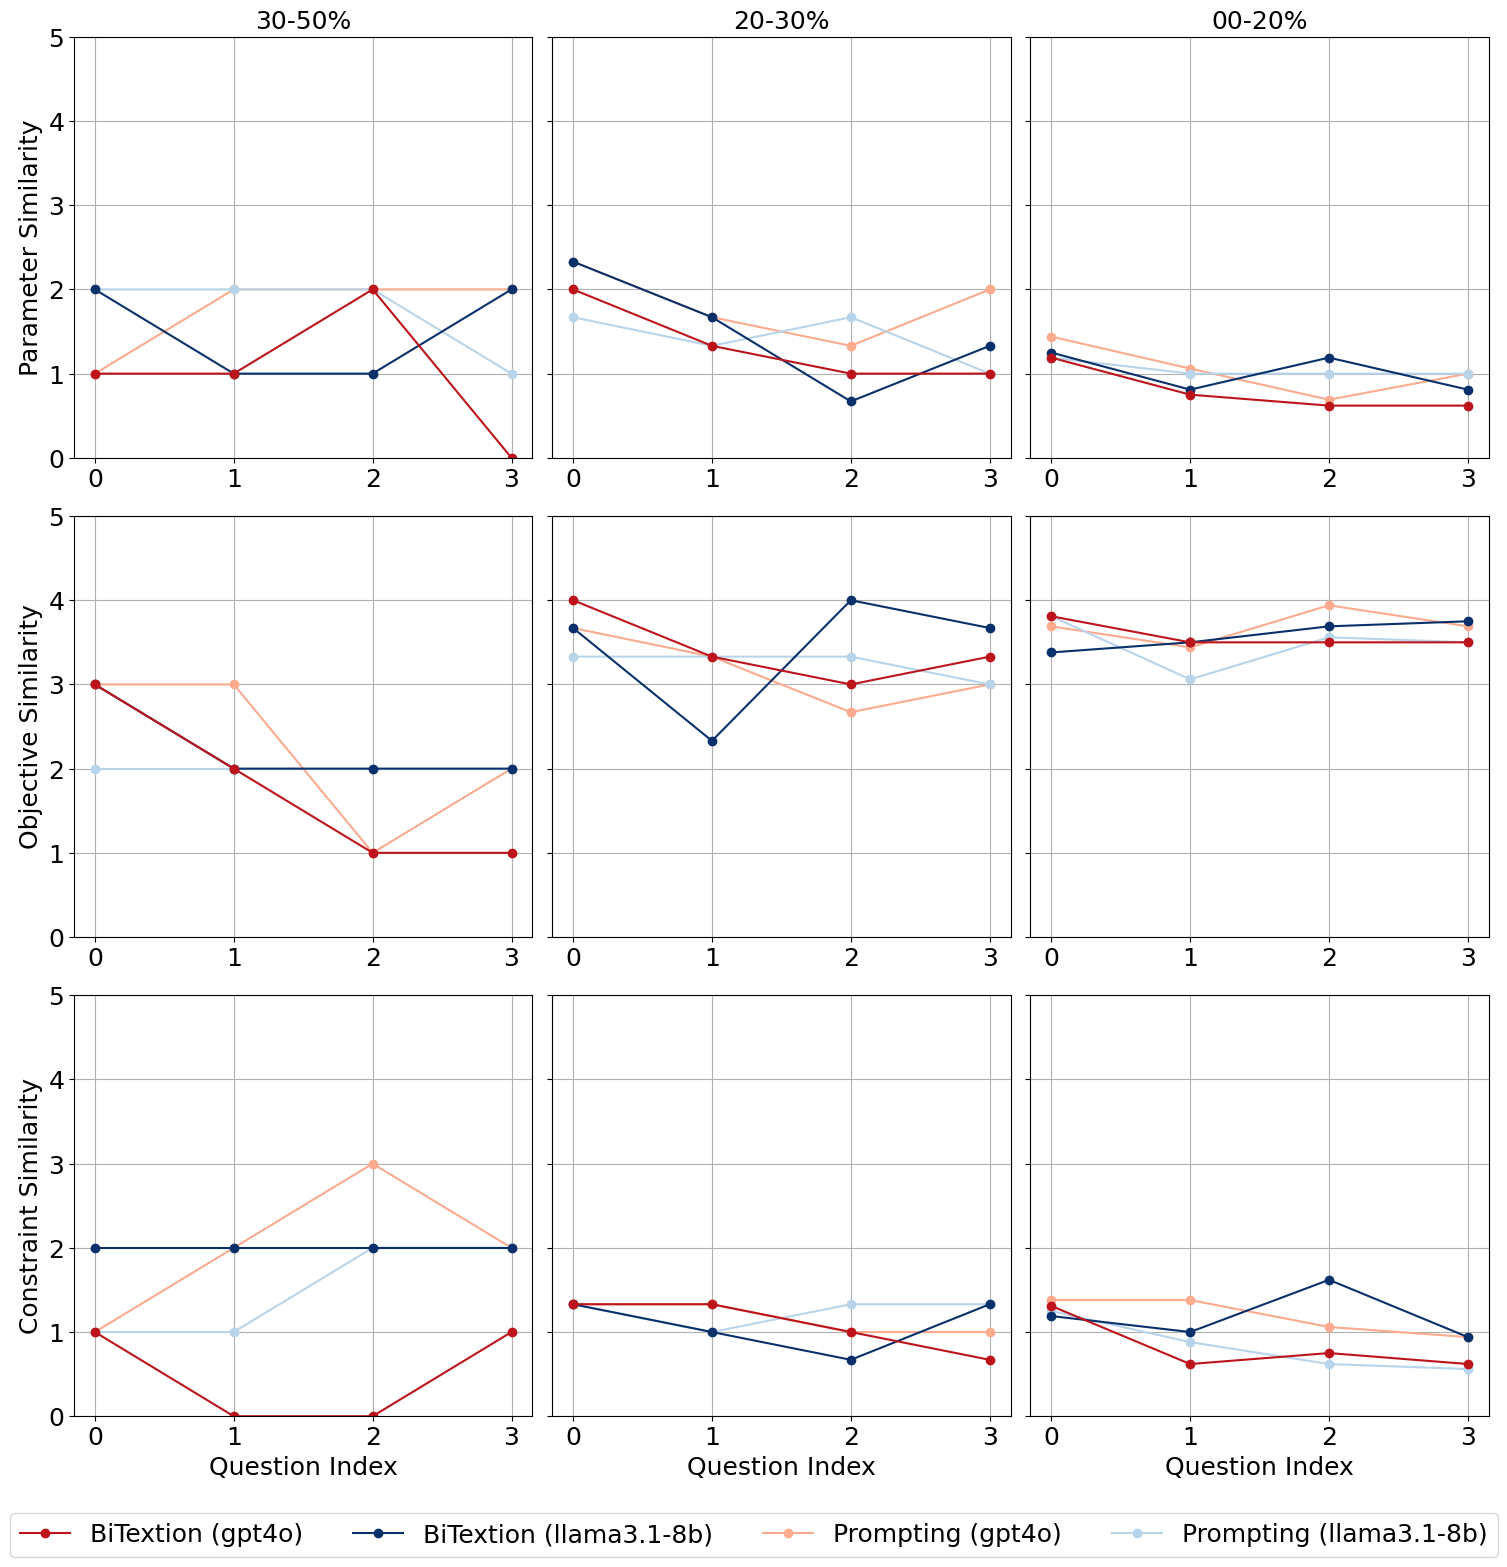

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# data
dict_for_groups = {}
for ratio in subset_length_ratio:
    dict_for_groups[ratio] = df[df['problem_idx'].isin(subset_length_ratio[ratio])].groupby(["question_idx", "model"])[["p_score", "o_score", "c_score"]].mean().round(2)
df_for_groups = pd.concat(dict_for_groups)

# unique ratios and models from df_for_groups
ratios = df_for_groups.index.get_level_values(0).unique()
models = df_for_groups.index.get_level_values('model').unique()
scores = ['p_score', 'o_score', 'c_score']
gpt4o_experts = ["Expert", "Expert_BiTextion"]
llama_experts = ["Expert_8b", "Expert_8b_BiTextion"]

# maps
ratio_map = {'1_05': "50-100%", '05_03': "30-50%", '03_02': "20-30%", '02_00': "00-20%"}
title_map = {
    "c_score": "Constraint Similarity",
    "p_score": "Parameter Similarity",
    "o_score": "Objective Similarity"
}
expert_map = {
    "Expert": "Prompting (gpt4o)",
    "Expert_BiTextion": "BiTextion (gpt4o)",
    "Expert_8b": "Prompting (llama3.1-8b)",
    "Expert_8b_BiTextion": "BiTextion (llama3.1-8b)",
}

# color maps
red_shades = plt.cm.Reds(np.linspace(0.3, 0.8, len(gpt4o_experts)))
blue_shades = plt.cm.Blues(np.linspace(0.3, 1, len(llama_experts)))
color_map = {}
for i, m in enumerate(gpt4o_experts):
    color_map[m] = red_shades[i]
for i, m in enumerate(llama_experts):
    color_map[m] = blue_shades[i]

# figure and subplots
fig, axes = plt.subplots(
    nrows=len(scores),
    ncols=len(ratios),
    figsize=(5 * len(ratios), 5 * len(scores)),
    sharey='row'
)
if len(ratios) == 1:
    axes = axes[:, None]
if len(scores) == 1:
    axes = axes[None, :]
for row_idx, score in enumerate(scores):
    for col_idx, ratio in enumerate(ratios):
        ax = axes[row_idx, col_idx]
        # subset of df for current ratio
        df_ratio = df_for_groups.loc[ratio]
        # pivot so that question_idx is rows and models are columns
        df_pivot = df_ratio.reset_index().pivot(index='question_idx', columns='model', values=score)
        # plot each model
        for m in models:
            if m in df_pivot.columns:
                ax.plot(
                    df_pivot.index,
                    df_pivot[m],
                    marker='o',
                    label=expert_map.get(m, m),
                    color=color_map.get(m, 'black')
                )
        ax.set_xticks(range(int(df_pivot.index.min()), int(df_pivot.index.max()) + 1))
        ax.tick_params(axis='x', labelsize=18)
        ax.tick_params(axis='y', labelsize=18)
        # score title only in the first column of each row
        if col_idx == 0:
            ax.set_ylabel(title_map.get(score, score), fontsize=18)
        # title for the ratio in the top row
        if row_idx == 0:
            ax.set_title(f'{ratio_map.get(ratio, ratio)}', fontsize=18)
        if row_idx == 2:
            ax.set_xlabel('Question Index', fontsize=18)
        ax.grid(True, axis='both', which='both')

# adjust y-limits
for ax_row in axes:
    for ax in ax_row:
        ax.set_ylim(0, 5)
        # ax.set_xlim(0, 3)
# legend
handles, labels = axes[-1, -1].get_legend_handles_labels()
# remove duplicates
seen = set()
unique_handles = []
unique_labels = []
for h, l in zip(handles, labels):
    if l not in seen:
        unique_handles.append(h)
        unique_labels.append(l)
        seen.add(l)
# sort legend
ordered_indices = sorted(range(len(unique_labels)), key=lambda i: unique_labels[i])
unique_handles = [unique_handles[i] for i in ordered_indices]
unique_labels = [unique_labels[i] for i in ordered_indices]
fig.legend(unique_handles, unique_labels, loc='lower center', bbox_to_anchor=(0.5, -0.05), ncol=4, fontsize=18)
plt.tight_layout()
plt.show()

In [12]:
### Table
df_for_groups.index = df_for_groups.index.set_names("ratio", level=0)
df_reset = df_for_groups.reset_index()
df_display = df_reset.pivot_table(
    index='question_idx',
    columns=['ratio', 'model'],
    values=['p_score', 'o_score', 'c_score'])
ratio_map = {'1_05': "50-100%", '05_03': "30-50%", '03_02': "20-30%", '02_00': "00-20%"}
title_map = {
    "c_score": "Constraint Similarity",
    "p_score": "Parameter Similarity",
    "o_score": "Objective Similarity"}
expert_map = {
    "Expert": "Prompting (gpt4o)",
    "Expert_BiTextion": "BiTextion (gpt4o)",
    "Expert_8b": "Prompting (llama3.1-8b)",
    "Expert_8b_BiTextion": "BiTextion (llama3.1-8b)",}
df_display = df_display.reorder_levels([1, 2, 0], axis=1).sort_index(axis=1)

In [13]:
def create_grouped_analysis(df, title_map, expert_map, ratio_map):
    if isinstance(df.index, pd.MultiIndex):
        df = df.reset_index()
    ratio_results = {}
    ratios = df['ratio'].unique()
    for ratio in ratios:
        ratio_df = df[df['ratio'] == ratio]
        pivot_df = ratio_df.groupby(["question_idx", "model"])[["p_score", "o_score", "c_score"]].mean().round(2)
        pivot_df = pivot_df.pivot_table(
            index='question_idx',
            columns=['model'],
            values=['p_score', 'o_score', 'c_score']
        )
        if expert_map:
            pivot_df = pivot_df.rename(columns=expert_map)
        readable_ratio = ratio_map.get(ratio, f"Ratio {ratio}")
        ratio_results[readable_ratio] = pivot_df
    return ratio_results
ratio_analyses =pd.concat(create_grouped_analysis(df_for_groups, title_map, expert_map, ratio_map))
ratio_analyses.to_csv("reg_data_complexor.csv")